# Draft Report

Mckenna Cooper (Colorado State University)  
Sarah Culhane (Colorado State University)  
Archer Goodman (Colorado State University)

# Lab 9: Project Updates (Results and Discussion)

## Methods

Our analysis focused on assessing the relationship between riparian vegetation characteristics and the diversity of freshwater macroinvertebrates, especially EPT taxa (Ephemeroptera, Plecoptera, Trichoptera), in Lassen Volcanic National Park for the years 2013 and 2019. We began by loading three datasets: InvertSpecies.csv, RiparianCover.csv, and WaterQuality.csv, filtering each to include only observations from Lassen Volcanic National Park in the target years. Using shared identifiers (Lake_Code, Start_Date, Park_Name), we merged the datasets for each year to create two comprehensive data frames, one for 2013 and one for 2019. To evaluate invertebrate community health, we calculated an EPT Score, defined as the ratio of EPT taxa counts to non-EPT taxa counts for each sampling date. Riparian vegetation quality was proxied through the categorical variable Barren_AreaCcover, which we converted into a numerical estimate of vegetative cover. We selected the 2013 dataset to build and evaluate a random forest regression model predicting EPT Score using water-quality and vegetation-related predictors: temperature in celsius, pH, dissolved oxygen, and estimated vegetative cover. Data was split into training and testing sets using initial_split(), and a cross-validation strategy (vfold_cv) was applied. We tuned model hyperparameters using tune_grid() and finalized the model based on RMSE performance. To visualize patterns and support interpretation, we generated several plots using ggplot2, including: Bar plots comparing insect order abundances by year

Boxplots of water quality metrics across years

A correlation heatmap to assess relationships between water quality parameters, EPT scores, and vegetation

A barren cover comparison plot between 2013 and 2019

All analyses were conducted in RStudio using the tidymodels, dplyr, and ggplot2 packages.

## Drafting the Results

### Data Prep & Modeling:

In [ ]:
#Loading Libraries
library(ggplot2)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.4.0     ✔ tibble       3.2.1
✔ infer        1.0.7     ✔ tidyr        1.3.1
✔ modeldata    1.4.0     ✔ tune         1.3.0
✔ parsnip      1.3.0     ✔ workflows    1.2.0
✔ purrr        1.0.4     ✔ workflowsets 1.1.0
✔ recipes      1.1.1     ✔ yardstick    1.3.2

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

In [ ]:
#Load data
invert_species <- read.csv("InvertSpecies.csv")
riparian_cover <- read.csv("RiparianCover.csv")
water_quality <- read.csv("WaterQuality.csv")

# Filter for Lassen Volcanic National Park and our year of 2013
invert_species_2013 <- invert_species %>%
  filter(Park_Name == "Lassen Volcanic National Park" & 
           (Start_Date >= as.Date("2013-01-01") & 
           Start_Date <= as.Date("2013-12-31")) |
           (Start_Date >= as.Date("2019-01-01") & 
           Start_Date <= as.Date("2019-12-31")))

riparian_cover_2013 <- riparian_cover %>%
  filter(Park_Name == "Lassen Volcanic National Park" & 
           (Start_Date >= as.Date("2013-01-01") & 
           Start_Date <= as.Date("2013-12-31")) | 
           (Start_Date >= as.Date("2019-01-01") & 
           Start_Date <= as.Date("2019-12-31")))

water_quality_2013 <- water_quality %>%
  filter(Park_Name == "Lassen Volcanic National Park" & 
           (Start_Date >= as.Date("2013-01-01") & 
           Start_Date <= as.Date("2013-12-31")) |
           (Start_Date >= as.Date("2019-01-01") & 
           Start_Date <= as.Date("2019-12-31")))

# Merge datasets
merged_data_2013 <- invert_species_2013 %>%
  inner_join(riparian_cover_2013, by = c("Lake_Code", "Park_Name", "Start_Date")) %>%
  inner_join(water_quality_2013, by = c("Lake_Code", "Park_Name", "Start_Date"))

Warning in inner_join(., riparian_cover_2013, by = c("Lake_Code", "Park_Name", : Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.

Warning in inner_join(., water_quality_2013, by = c("Lake_Code", "Park_Name", : Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.

Warning in inner_join(., riparian_cover_2019, by = c("Lake_Code", "Park_Name", : Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.

Warning in inner_join(., water_quality_2019, by = c("Lake_Code", "Park_Name", : Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.

In [ ]:
#setting up some useful metrics, limiting data to stuff we need
melded_data_2013 <- merged_data_2013 |>
  mutate(EPT_taxa = ifelse(Order == "Ephemeroptera" |
                             Order == "Plecoptera" |
                             Order == "Trichoptera", 
                           "Yes", "No"),
         Veg_Cover = case_when(
           Barren_AreaCcover == "sparse (<10%)" ~ 0.05,
           Barren_AreaCcover == "moderate (10-40%)" ~ 0.25,
           Barren_AreaCcover == "heavy (40-75%)" ~ 0.57,
           Barren_AreaCcover == "very heavy (>75%)" ~ 0.87)) |>
  summarize(Unit_Code, 
            Park_Name, 
            Lake_Code, 
            Start_Date, 
            Order, 
            Count, 
            EPT_taxa, 
            Veg_Cover, 
            Temperature_C,
            Dissolved_oxygen, 
            pH, 
            Depth_m, 
            Turbidity, 
            )

dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.

Rows: 217,950
Columns: 16
$ Unit_Code        <chr> "CRLA", "CRLA", "CRLA", "CRLA", "CRLA", "CRLA", "CRLA…
$ Park_Name        <chr> "Crater Lake National Park", "Crater Lake National Pa…
$ Lake_Code        <chr> "CRLAWQL04", "CRLAWQL04", "CRLAWQL04", "CRLAWQL04", "…
$ Start_Date       <chr> "2019-09-10", "2019-09-10", "2019-09-10", "2019-09-10…
$ Order            <chr> "Trichoptera", "Trichoptera", "Trichoptera", "Trichop…
$ Count            <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ EPT_taxa         <chr> "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes…
$ Veg_Cover        <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 0.25,…
$ Temperature_C    <dbl> 13.61, 13.60, 13.72, 13.69, 13.61, 13.60, 13.72, 13.6…
$ Dissolved_oxygen <dbl> 6.07, 6.12, 7.15, 6.53, 6.07, 6.12, 7.15, 6.53, 6.07,…
$ pH               <dbl> 6.59, 6.61, 6.65, 6.61, 6.59, 6.61, 6.65, 6.61, 6.59,…
$ Depth_m          <dbl> 1.12, 1.03, 0.00, 0.50, 1.12, 1.03, 0.00, 0.50, 1.12,…
$ Turbidity   

dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.

i Creating pre-processing data to finalize unknown parameter: mtry

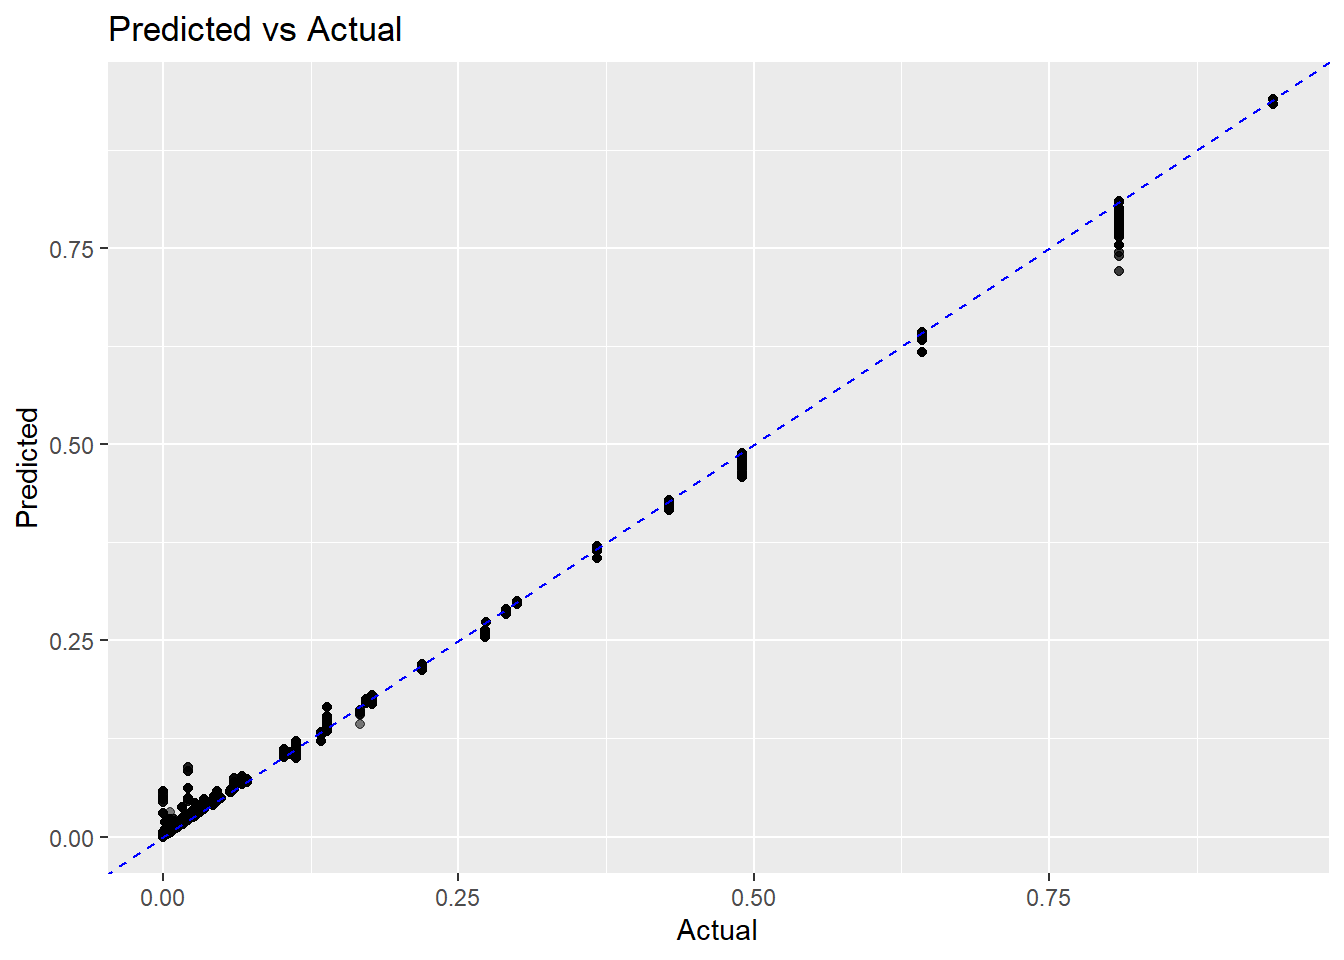

In [ ]:
#Conduct a test. 
set.seed(15379)
#used my old robotics team's number for the seed, easy for me to remember

#We're gonna do this with just 2013 data for right now
#giving my data splits catchy names 
banana_split <- initial_split(melded_data_2013, prop = 0.8)
#Chocolate > choochoo > train > training data
choco_choochoo <- training(banana_split)
#vanilla > vanilla ice > mic check "testing testing" > testing data
vanilla_ice_mic <- testing(banana_split)

#glimpse(choco_choochoo)

#specifying a recipe
sundae_recipe <- recipe(EPT_Score ~ 
                          Start_Date +
                          Veg_Cover + 
                          Temperature_C + 
                          Dissolved_oxygen + 
                          pH + 
                          Depth_m + 
                          Turbidity, 
                        data = choco_choochoo) |>
  step_normalize(all_numeric_predictors())

#specifying a model
icecream_model <- rand_forest(mtry = tune(), trees = 250, min_n = 500) |>
  set_engine("ranger") |>
  set_mode("regression")

#creating workflow
icecream_scoop <- workflow() |>
  add_model(icecream_model) |>
  add_recipe(sundae_recipe)

#testing the model with cross_validation
#validating the process for making a new icecream flavor
validated_process <- vfold_cv(vanilla_ice_mic, v = 5)
#tuning the model
salt_to_taste <- tune_grid(
  icecream_scoop,
  resamples = validated_process,
  grid = 10
)

## For Taxa Order

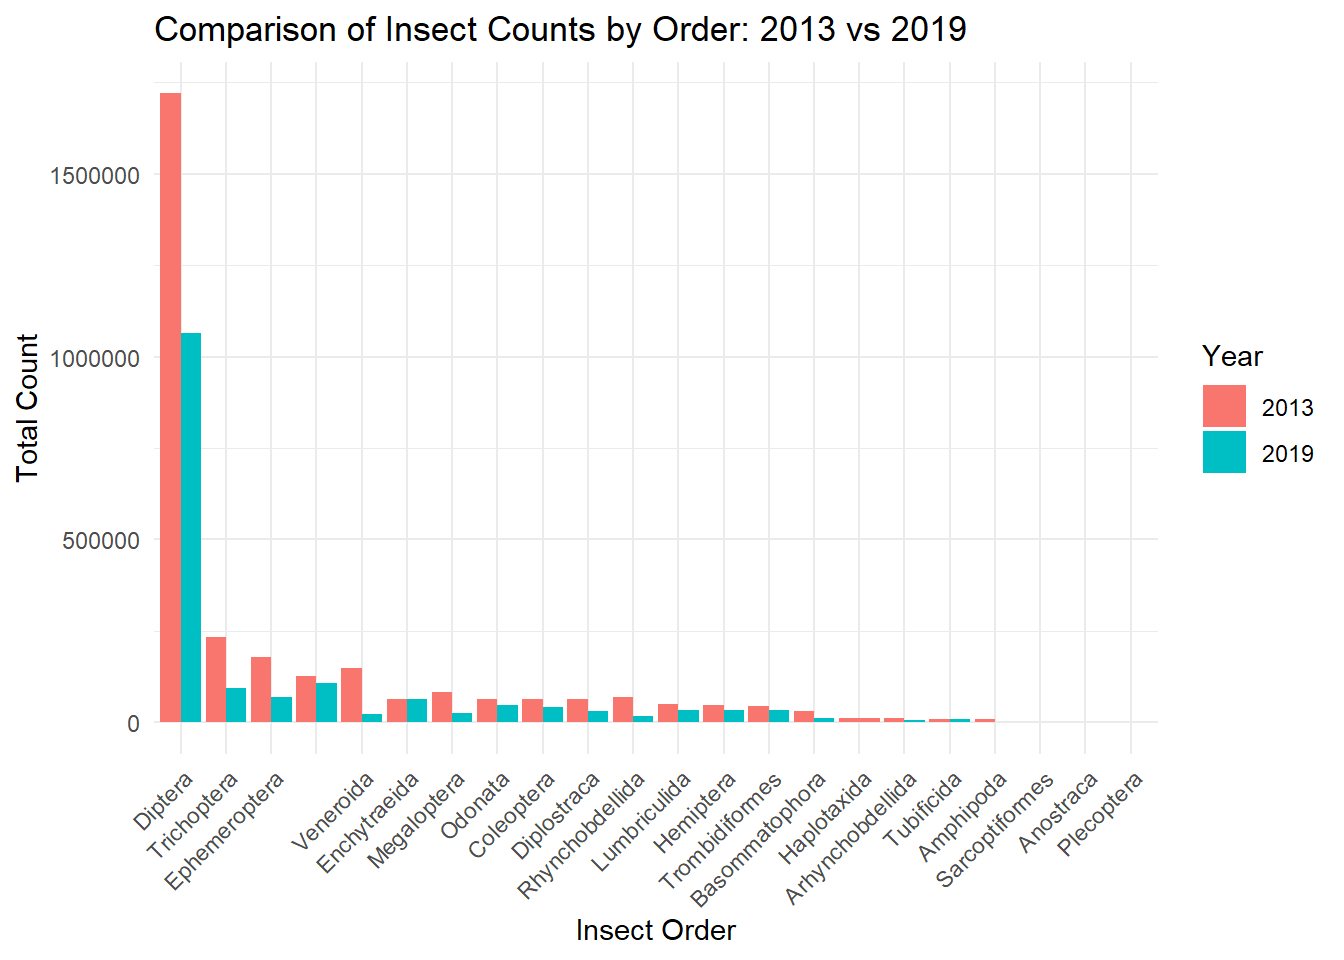

In [ ]:
# Summarize 2013 data
insect_order_counts_2013 <- melded_data_2013 %>%
  filter(Park_Name == "Lassen Volcanic National Park") %>%
  group_by(Order) %>%
  summarise(Total_Count = sum(Count, na.rm = TRUE)) %>%
  mutate(Year = 2013)

# Summarize 2019 data
insect_order_counts_2019 <- melded_data_2019 %>%
  filter(Park_Name == "Lassen Volcanic National Park") %>%
  group_by(Order) %>%
  summarise(Total_Count = sum(Count, na.rm = TRUE)) %>%
  mutate(Year = 2019)

# Combine both
insect_order_counts_combined <- bind_rows(insect_order_counts_2013, insect_order_counts_2019)

# Plot
ggplot(insect_order_counts_combined, aes(x = reorder(Order, -Total_Count), y = Total_Count, fill = factor(Year))) +
  geom_col(position = "dodge") +
  labs(
    title = "Comparison of Insect Counts by Order: 2013 vs 2019",
    x = "Insect Order",
    y = "Total Count",
    fill = "Year"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## For Barren Cover

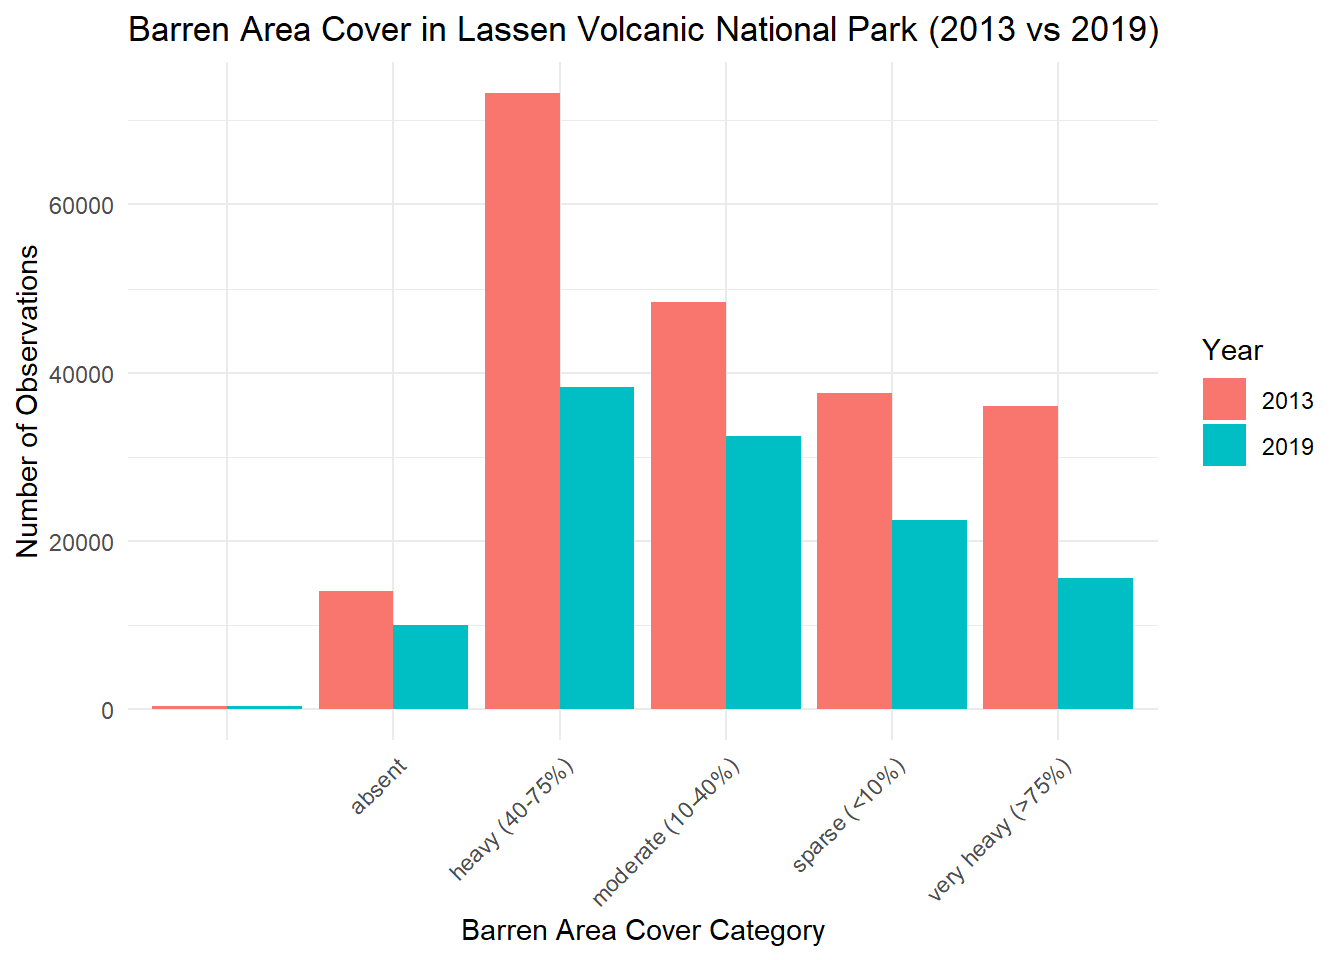

In [ ]:
# Add year column to each dataset
barren_2013 <- merged_data_2013 %>%
  filter(Park_Name == "Lassen Volcanic National Park") %>%
  select(Barren_AreaCcover) %>%
  mutate(Year = 2013)

barren_2019 <- merged_data_2019 %>%
  filter(Park_Name == "Lassen Volcanic National Park") %>%
  select(Barren_AreaCcover) %>%
  mutate(Year = 2019)

# Combine both
barren_combined <- bind_rows(barren_2013, barren_2019)

# Plot
ggplot(barren_combined, aes(x = Barren_AreaCcover, fill = factor(Year))) +
  geom_bar(position = "dodge") +
  labs(
    title = "Barren Area Cover in Lassen Volcanic National Park (2013 vs 2019)",
    x = "Barren Area Cover Category",
    y = "Number of Observations",
    fill = "Year"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## For Water Quality Box Plots

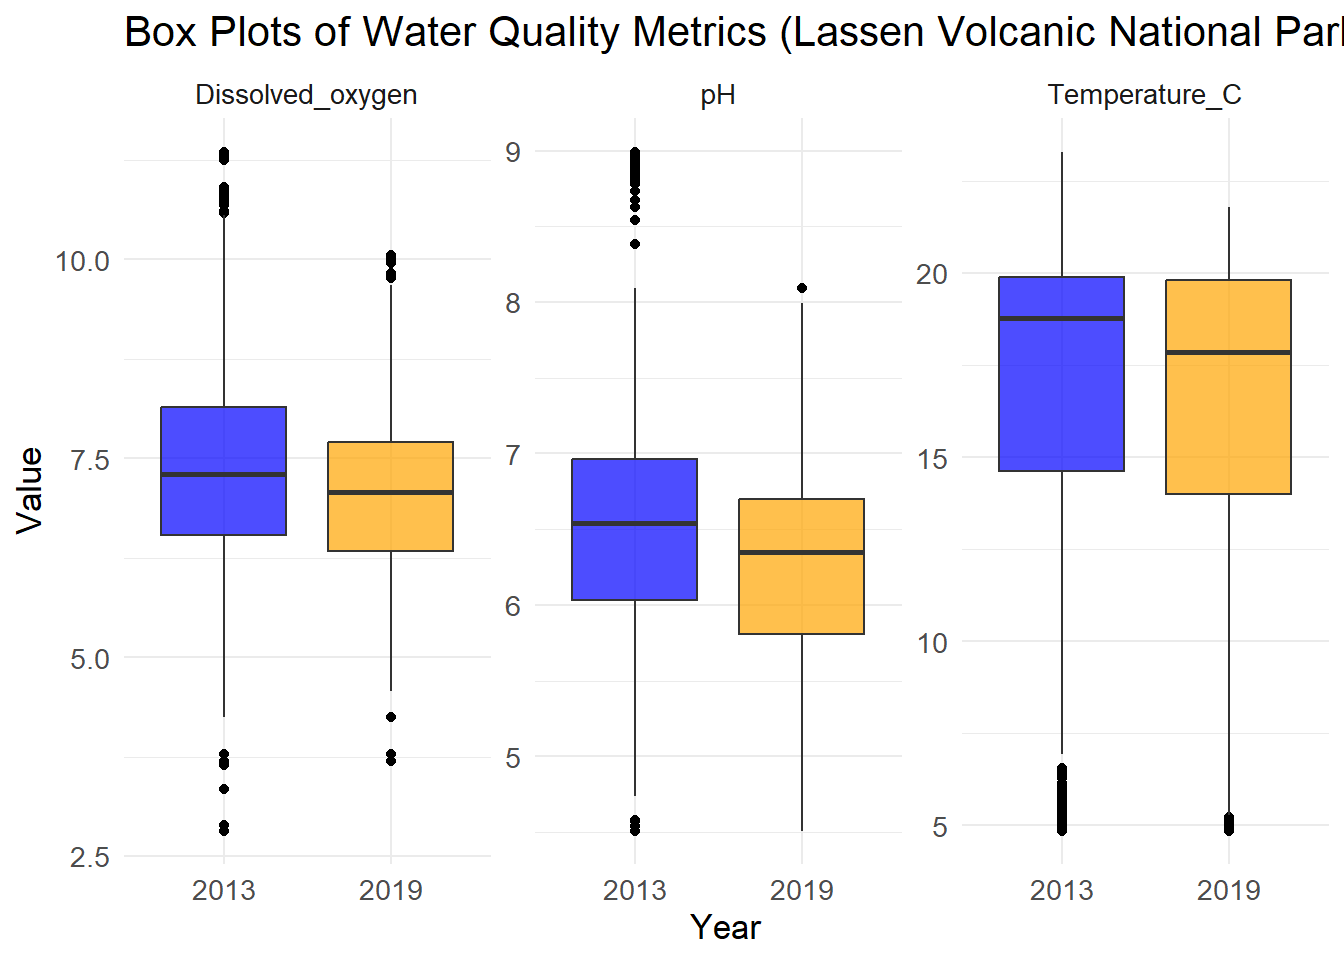

In [ ]:
# Combine data, reshape, and filter
water_quality_box <- bind_rows(
  melded_data_2013 %>% mutate(Year = "2013"),
  melded_data_2019 %>% mutate(Year = "2019")
) %>%
  filter(Park_Name == "Lassen Volcanic National Park") %>%
  select(Temperature_C, Dissolved_oxygen, pH, Year) %>%
  drop_na() %>%
  pivot_longer(cols = c(Temperature_C, Dissolved_oxygen, pH),
               names_to = "Metric", values_to = "Value")

# Create box plot
ggplot(water_quality_box, aes(x = Year, y = Value, fill = Year)) +
  geom_boxplot(alpha = 0.7, outlier.color = "black") +
  facet_wrap(~ Metric, scales = "free_y") +
  labs(
    title = "Box Plots of Water Quality Metrics (Lassen Volcanic National Park)",
    x = "Year",
    y = "Value"
  ) +
  scale_fill_manual(values = c("2013" = "blue", "2019" = "orange")) +
  theme_minimal() +
  theme(text = element_text(size = 13), legend.position = "none")

## For Correlation Heat Map


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

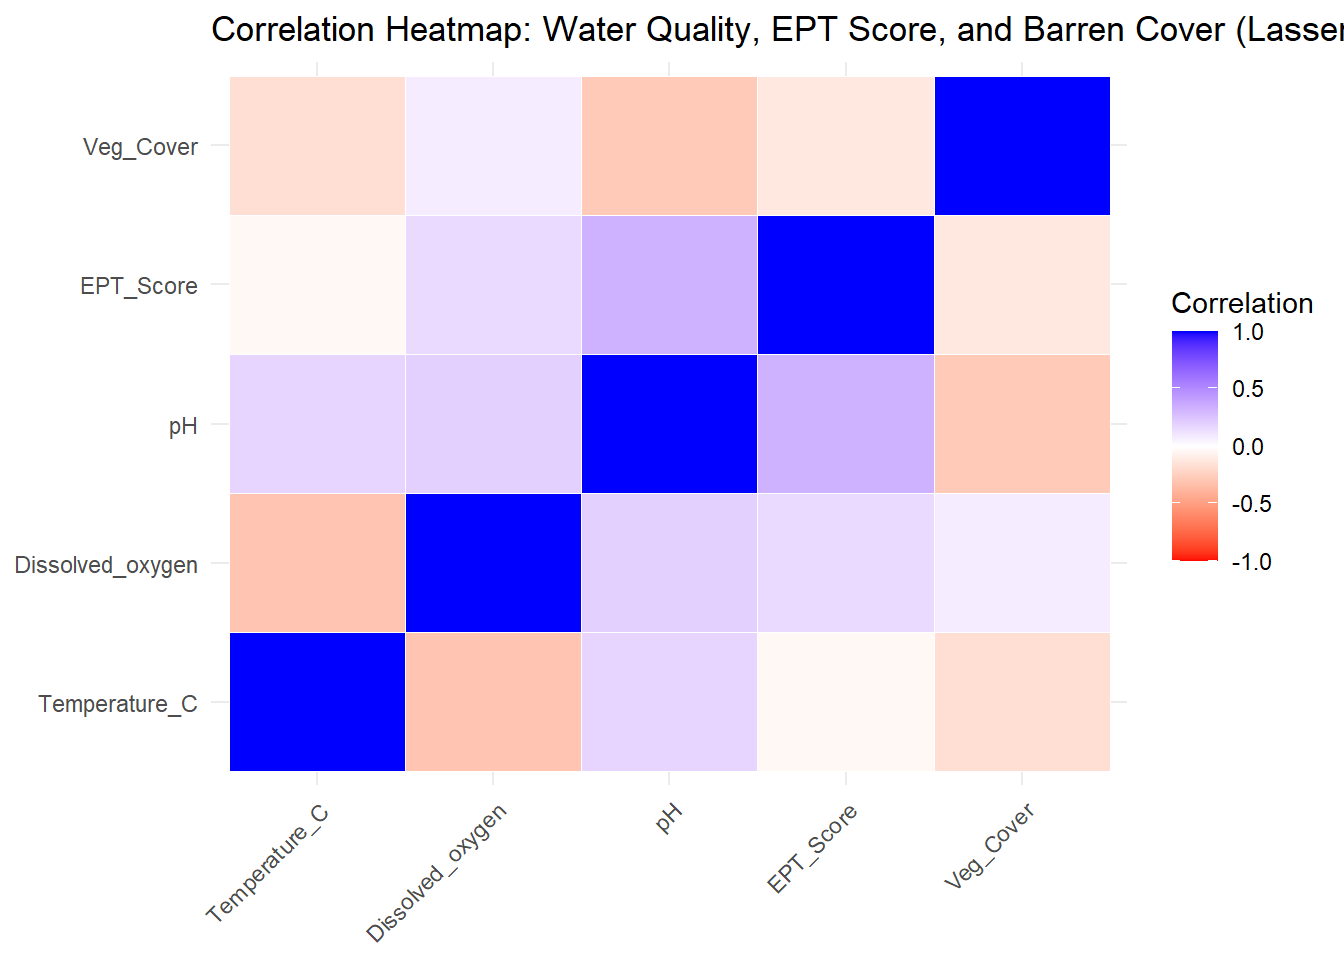

In [ ]:
# Combine 2013 and 2019 data, filter, and select relevant columns
cor_data_full <- bind_rows(
  melded_data_2013 %>% mutate(Year = "2013"),
  melded_data_2019 %>% mutate(Year = "2019")
) %>%
  filter(Park_Name == "Lassen Volcanic National Park") %>%
  select(Temperature_C, Dissolved_oxygen, pH, EPT_Score, Veg_Cover) %>%
  drop_na()

# Compute correlation matrix
cor_matrix_full <- cor(cor_data_full, use = "complete.obs")

# Reshape for heatmap
library(reshape2)

## Discussion

Results suggest that there was an overall decline in macroinvertebrate taxa richness across all orders between 2013 and 2019 in water bodies within Lassen Volcanic National Park. The strong positive correlation between pH, dissolved oxygen, and EPT_score suggests that the decline in pH and dissolved oxygen present in those water bodies may have been partially responsible for the decline in taxa richness. Vegetation present in riparian zones within the park seemed to have increased, according to our analysis, and veg_cover and EPT_score seem to have a negative correlation. This suggests that as vegetation cover increased, taxa richness decreased, which goes against our hypothesis that more riparian cover would lead to high taxa richness. The cause of this is unknown and warrants further research. Going forward, more focused research and data collection needs to be done to find the source of pollution in Lassen Volcanic National Park so that measures can be taken to combat pollution at the source and improve the water quality of water bodies within the park. Limitations of our analysis include the fact that there was a lot of cleaning that had to be done in our dataset, and there was a disproportionate amount of data for each of the national parks and years that data was collected, with some parks and years having significantly more data than others. Crater Lake National Park especially had less data than both Volcanic National Park and Redwood National State Park.